# Assignment 2: IR

## Preparations
* Put all your imports, and path constants in the next cells
* Make sure all your path constants are **relative to** ***DATA_DIR*** and **NOT hard-coded** in your code.

In [1]:
!pip install whoosh
!pip install pytrec_eval
!pip install wget

In [0]:
# imports
# Put all your imports herefrom whoosh import index, writing
from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh import qparser
from whoosh.analysis import *
from whoosh.qparser import QueryParser
from whoosh import scoring
import os.path
from pathlib import Path
import tempfile
import subprocess
import pytrec_eval
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
from whoosh.analysis import Filter
import wget

In [3]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/government.zip", "government.zip")

'government (1).zip'

In [4]:
!unzip government.zip

Archive:  government.zip
replace government/topics-with-full-descriptions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: government/topics-with-full-descriptions.txt  
  inflating: government/gov.topics   
  inflating: government/gov.qrels    
  inflating: government/documents/61/G00-61-2800209  
  inflating: government/documents/61/G00-61-1192048  
  inflating: government/documents/61/G00-61-1118212  
  inflating: government/documents/61/G00-61-0749882  
  inflating: government/documents/61/G00-61-2230501  
  inflating: government/documents/61/G00-61-0680698  
  inflating: government/documents/61/G00-61-0551387  
  inflating: government/documents/61/G00-61-2575433  
  inflating: government/documents/61/G00-61-0469713  
  inflating: government/documents/61/G00-61-0280746  
  inflating: government/documents/61/G00-61-2574316  
  inflating: government/documents/61/G00-61-3933997  
  inflating: government/documents/61/G00-61-3290635  
  inflating: government/documents/61/G00-61

In [0]:
DATA_DIR = "government"
#
# Put other path constants here
#
DOCUMENTS_DIR = os.path.join(DATA_DIR, "documents")
TOPIC_FILE = os.path.join(DATA_DIR, "gov.topics")
QRELS_FILE = os.path.join(DATA_DIR, "gov.qrels")

## Question 1
Provide your text answers in the following two markdown cells

### Q1 (a): Provide answer to Q1 (a) here [markdown cell]

**Answer Q1(a):** Rprec

### Q1 (b): Provide answer to Q1 (b) here [markdown cell]

**Answer Q1(b):**

Rprec measures the percent of relevant results from top R queries retrieved which is suitable for government websites as the objective is that the user spends less time for more accurate results.

### Q2 (a): Write your code below

In [0]:
# Put your code for creating the index here (you can add more cells).
# Make sure you save the final index in the variable INDEX_Q2, your query parser in QP_Q2, and your searcher in SEARCHER_Q2
def createIndex(schema):
    # Generate a temporary directory for the index
    indexDir = tempfile.mkdtemp()

    # create and return the index
    return index.create_in(indexDir, schema)

In [0]:
def addFilesToIndex(indexObj, fileList):
    # open writer
    writer = writing.BufferedWriter(indexObj, period=None, limit=1000)

    try:
        # write each file to index
        for docNum, filePath in enumerate(fileList):
            with open(filePath, "r", encoding="utf-8") as f:
                fileContent = f.read()
                writer.add_document(file_path = filePath,
                                    file_content = fileContent)

                # print status every 1000 documents
                if (docNum+1) % 1000 == 0:
                    print("already indexed:", docNum+1)
        print("done indexing.")

    finally:
        # close the index
        writer.close()

In [0]:
# Build a list of files to index
filesToIndex = [str(filePath) for filePath in Path(DOCUMENTS_DIR).glob("**/*") if filePath.is_file()]

In [9]:
# Check the list
filesToIndex[:5]

['government/documents/68/G00-68-3094820',
 'government/documents/68/G00-68-0361254',
 'government/documents/68/G00-68-2512403',
 'government/documents/68/G00-68-0000000',
 'government/documents/68/G00-68-1332243']

In [0]:
# first, define a Schema for the index
mySchema2 = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = RegexTokenizer()))

# now, create the index at the path INDEX_DIR based on the new schema
myIndex = createIndex(mySchema2)

In [0]:
INDEX_Q2=myIndex # Replace None with your index for Q2

In [12]:
# count files to index
print("number of files:", len(filesToIndex))

number of files: 4078


In [13]:
addFilesToIndex(INDEX_Q2, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [0]:
QP_Q2 = QueryParser("file_content", schema=INDEX_Q2.schema)# Replace None with your query parser for Q2
SEARCHER_Q2 = INDEX_Q2.searcher() # Replace None with your searcher for Q2

In [0]:
def pyTrecEval(topicFile, qrelsFile, queryParser, searcher):
    # Load topic file - a list of topics(search phrases) used for evalutation
    with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()

    # create an output file to which we'll write our results
    tempOutputFile = tempfile.mkstemp()[1]
    with open(tempOutputFile, "w") as outputTRECFile:
        # for each evaluated topic:
        # build a query and record the results in the file in TREC_EVAL format
        for topic in topics:
            topic_id, topic_phrase = tuple(topic.split(" ", 1))
            #print(topic_id, topic_phrase)
            topicQuery = queryParser.parse(topic_phrase)
            topicResults = searcher.search(topicQuery, limit=None)
            for (docnum, result) in enumerate(topicResults):
                score = topicResults.score(docnum)
                #print("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
                outputTRECFile.write("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
    with open(qrelsFile, 'r') as f_qrel:
        qrel = pytrec_eval.parse_qrel(f_qrel)

    with open(tempOutputFile, 'r') as f_run:
        run = pytrec_eval.parse_run(f_run)

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrel, pytrec_eval.supported_measures)

    results = evaluator.evaluate(run)
    def print_line(measure, scope, value):
        print('{:25s}{:8s}{:.4f}'.format(measure, scope, value))

    for query_id, query_measures in results.items():
        for measure, value in query_measures.items():
            if measure == "runid":
              continue
            print_line(measure, query_id, value)
    for measure in query_measures.keys():
        if measure == "runid":
              continue
        print_line(
            measure,
            'all',
            pytrec_eval.compute_aggregated_measure(
                measure,
                [query_measures[measure]
                 for query_measures in results.values()]))

In [16]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q2, SEARCHER_Q2) 

num_q                    1       1.0000
num_ret                  1       1.0000
num_rel                  1       5.0000
num_rel_ret              1       0.0000
map                      1       0.0000
gm_map                   1       -11.5129
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0000
iprec_at_recall_0.00     1       0.0000
iprec_at_recall_0.10     1       0.0000
iprec_at_recall_0.20     1       0.0000
iprec_at_recall_0.30     1       0.0000
iprec_at_recall_0.40     1       0.0000
iprec_at_recall_0.50     1       0.0000
iprec_at_recall_0.60     1       0.0000
iprec_at_recall_0.70     1       0.0000
iprec_at_recall_0.80     1       0.0000
iprec_at_recall_0.90     1       0.0000
iprec_at_recall_1.00     1       0.0000
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0000
P_30                     1       0.000

In [0]:
def printRelName(topicFile, qrelsFile, queryParser, searcher, id):
  with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()
  for topic in topics:
        topic_id, topic_phrase = tuple(topic.split(" ", 1))
        if topic_id == id:
          print("---------------------------Topic_id and Topic_phrase----------------------------------")
          print(topic_id, topic_phrase)
          topicQuery = queryParser.parse(topic_phrase)
          topicResults = searcher.search(topicQuery, limit=None)
          print("---------------------------Return documents----------------------------------")
          for (docnum, result) in enumerate(topicResults):
              score = topicResults.score(docnum)
              print("%s Q0 %s %d %lf test" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
          print("---------------------------Relevant documents----------------------------------")
          with open(qrelsFile, 'r') as f_qrel:
            qrels = f_qrel.readlines()
            for i in qrels:
              qid, _, doc, rel = i.rstrip().split(" ")
              if qid == id and rel == "1":
                print(i.rstrip())

In [18]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q2, SEARCHER_Q2, "4")

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-99-2247765 0 16.449155 test
4 Q0 G00-85-1525415 1 13.364613 test
4 Q0 G00-05-1218739 2 12.956314 test
4 Q0 G00-09-0774298 3 11.781349 test
4 Q0 G00-56-4151981 4 11.367248 test
4 Q0 G00-21-2229498 5 10.743958 test
4 Q0 G00-98-4068688 6 10.464865 test
4 Q0 G00-47-2117970 7 10.213356 test
4 Q0 G00-67-0152545 8 8.392871 test
4 Q0 G00-06-1757034 9 6.431556 test
4 Q0 G00-78-2551063 10 3.955775 test
4 Q0 G00-84-0274223 11 2.068438 test
---------------------------Relevant documents----------------------------------
4 0 G00-03-2855342 1
4 0 G00-36-1275993 1
4 0 G00-47-2117970 1
4 0 G00-65-0162935 1


In [19]:
# define a reader object on the index
myReader_Q2 = INDEX_Q2.reader()
#how many terms do we have?
print(myReader_Q2.field_length("file_content"))
# how many documents have the phrases "cotton", industry" in the field "file_content"?
print("# docs with 'wireless'", myReader_Q2.doc_frequency("file_content", "wireless"))
print("# docs with 'communications'", myReader_Q2.doc_frequency("file_content", "communications"))
# how many phrases "cotton", industry" are there in the field "file_content"?
print("# phrases with 'wireless'", myReader_Q2.frequency("file_content", "wireless"))
print("# phrases with 'communications'", myReader_Q2.frequency("file_content", "communications"))

2165181
# docs with 'wireless' 33
# docs with 'communications' 102
# phrases with 'wireless' 77.0
# phrases with 'communications' 218.0


In [20]:
print('most unique terms in Q2 are:', myReader_Q2.most_distinctive_terms('file_content', number = 10))

most unique terms in Q2 are: [(15793.691041995347, b'the'), (12141.916574922074, b'and'), (11322.7204750335, b'in'), (11181.871195315607, b'of'), (10654.852924162624, b'a'), (9400.984123915898, b'Gamma'), (9029.37100448609, b'to'), (8612.666474197667, b'or'), (8594.365698247793, b'that'), (8174.513438585714, b'be')]


## Question 2

### Q2 (b): Provide answer to Q2 (b) here [markdown cell]

**Answer Q2(b):**

Rprec for the baseline Whoosh system = 0.1667

### Q2 (c): Provide answer to Q2(c) here [markdown cell]

**Answer Q2(c):**

Topic ID's with good performance of Rprec: 18, 24, 26

Topic ID's with bad performance of Rprec: 1, 2, 4, 6, 7, 9, 10, 14, 16, 19, 22

## Question 3

### Q3 (a): Provide answer to Q3 (a) here [markdown cell]

**Answer Q3(a):**

The chosen query for this analysis is Topic Id: 4 **wireless communications**

**Reason for choosing this topic:**

The following document contains many **False Positives** (documents retrieved that were highly ranked and should not have been) and **False Negatives** (documents that should have been highly ranked and weren't). While going from baseline Q2 to Q3, improvement was observed for this document and hence it was selected.


**Documents that were highly ranked were:**

These documents were **False Positives**

1 G00-99-2247765

2 G00-85-1525415

3 G00-05-1218739

4 G00-09-0774298

5 G00-56-4151981

6 G00-21-2229498

**Documents that should have been highly ranked:**

These documents were **False Negatives**

1 G00-03-2855342

2 G00-36-1275993

3 G00-47-2117970

4 G00-65-0162935

**False Negatives Analysis:** G00-47-2117970 (chosen document)

Tokens for this document are: ['wireless', 'communications']

In this question, the analyzer only consists of RegexTokenizer(), which dosen't consider the case sensitive nature of the query that have been parsed. For example, the query parsed was ['wireless', 'communications'] but the analyzer would not have returned the results is the document contained the words 'Wireless' and 'Communications'.

The counted term frequency for the document G00-47-2117970 when this analyser was used for 'wireless' and 'communications' was 2 and 6. The actual frequency count for the same document was 13 and 11 respectfully.

It was further noticed that the default parser treats the words as if they were connected by AND statement thereby stating that all terms should be present for the document to match which should not happen. [https://whoosh.readthedocs.io/en/latest/parsing.html]

Hence, we can see that for the document G00-47-2117970 the parsed query ['wireless', 'communications'] was not retrieved as intended and therefore this substitutes as a **False Negative.**

**False Positive Analysis:** G00-05-1218739 (chosen document)

Similar to the analysis done above, the term frequency of 'wireless' and 'communications' for the document G00-05-1218739 was found to be 4 and 3.
Since both the words are obtained in almost equal proportions, this document was retrieved and highly ranked compared to the documents that should have been ranked higher.

**By further inspecting the Index_Q2 we found:**

Total terms: 2165181

%% docs with 'wireless' 33

%%docs with 'communications' 102.0

%%phrases with 'wireless' 77.0

%%phrases with 'communications' 218.0

Furthermore, it was also found that the most unique terms in Q2 are stopwords: [(15793.691041995347, b'the'), (12141.916574922074, b'and'), (11322.7204750335, b'in'), (11181.871195315607, b'of'), (10654.852924162624, b'a'), (9400.984123915898, b'Gamma'), (9029.37100448609, b'to'), (8612.666474197667, b'or'), (8594.365698247793, b'that'), (8174.513438585714, b'be')]

**Some of the Suggested Modifications are:**

1. Use of the LowercaseFilter() in the analyzer
> **Justification:** Since the RegexTokenizer() dosen't recognize case sensitivity, this analyzer along with RegexTokenizer() will solve that issue.
2. Configuring the query parser to include the 'OR' conditionality statement
> **Justification:** Since the default query parser considers words with a default AND contraint, this parser will now give individual words 'wireless' OR 'communications' and hence the query will be matched and retreived accurately.
3. Use of StopFilter()
> **Justification:** This will aid in removal of stopwords and hence provide a higher weightage to the rarrer terms in the document.




### Q3 (b): Write your code below

In [0]:
# Put your code for creating the index here (you can add more cells).
LwrStpAnalyzer = RegexTokenizer() | LowercaseFilter() | StopFilter()
# Make sure you save the final index in the variable INDEX_Q3, your query parser in QP_Q3, and your searcher in SEARCHER_Q3
mySchema3 = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = LwrStpAnalyzer))

In [22]:
# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q3 = createIndex(mySchema3) # Replace None with your index for Q3
addFilesToIndex(INDEX_Q3, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [0]:
QP_Q3 = QueryParser("file_content", schema=INDEX_Q3.schema,group=qparser.OrGroup)# Replace None with your query parser for Q3
SEARCHER_Q3 = INDEX_Q3.searcher() # Replace None with your searcher for Q3

In [24]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q3, SEARCHER_Q3) 

num_q                    1       1.0000
num_ret                  1       200.0000
num_rel                  1       5.0000
num_rel_ret              1       3.0000
map                      1       0.0308
gm_map                   1       -3.4796
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0588
iprec_at_recall_0.00     1       0.0690
iprec_at_recall_0.10     1       0.0690
iprec_at_recall_0.20     1       0.0690
iprec_at_recall_0.30     1       0.0690
iprec_at_recall_0.40     1       0.0690
iprec_at_recall_0.50     1       0.0263
iprec_at_recall_0.60     1       0.0263
iprec_at_recall_0.70     1       0.0000
iprec_at_recall_0.80     1       0.0000
iprec_at_recall_0.90     1       0.0000
iprec_at_recall_1.00     1       0.0000
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0500
P_30                     1       0.06

In [25]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q3, SEARCHER_Q3, "4")

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-36-1275993 0 17.452534 test
4 Q0 G00-47-2117970 1 16.803991 test
4 Q0 G00-00-1958915 2 15.419385 test
4 Q0 G00-28-2286602 3 14.834750 test
4 Q0 G00-99-2247765 4 14.503729 test
4 Q0 G00-21-2229498 5 14.410003 test
4 Q0 G00-74-4030396 6 14.228823 test
4 Q0 G00-85-1525415 7 14.211391 test
4 Q0 G00-05-1218739 8 14.014439 test
4 Q0 G00-69-0005329 9 14.005216 test
4 Q0 G00-46-1439567 10 13.715071 test
4 Q0 G00-84-3349019 11 13.661520 test
4 Q0 G00-16-0059045 12 13.259794 test
4 Q0 G00-44-1482914 13 13.111128 test
4 Q0 G00-71-3454228 14 12.795079 test
4 Q0 G00-02-1720397 15 12.714877 test
4 Q0 G00-09-0774298 16 11.918658 test
4 Q0 G00-07-3064254 17 11.811925 test
4 Q0 G00-67-0152545 18 10.938959 test
4 Q0 G00-05-1550998 19 10.415637 test
4 Q0 G00-72-3133704 20 10.220700 test
4 Q0 G00-54-0905235 2

In [26]:
# define a reader object on the index
myReader_Q3 = INDEX_Q3.reader()
#how many terms do we have?
print(myReader_Q3.field_length("file_content"))
# how many documents have the phrases "cotton", industry" in the field "file_content"?
print("# docs with 'wireless'", myReader_Q3.doc_frequency("file_content", "wireless"))
print("# docs with 'communications'", myReader_Q3.doc_frequency("file_content", "communications"))
# how many phrases "cotton", industry" are there in the field "file_content"?
print("# phrases with 'wireless'", myReader_Q3.frequency("file_content", "wireless"))
print("# phrases with 'communications'", myReader_Q3.frequency("file_content", "communications"))

1591655
# docs with 'wireless' 66
# docs with 'communications' 245
# phrases with 'wireless' 197.0
# phrases with 'communications' 601.0


In [27]:
[token.text for token in LwrStpAnalyzer("wireless communications")]

['wireless', 'communications']

### Q3 (c): Provide answer to Q3 (c) here [markdown cell]

**Answer Q3(c):** 

**Modifications made are:** 

1. Default query parser changed from AND to OR conditionality
2. Use of StopFilter()
3. Use of LowercaseFilter()

**Analysis for Q3:** The chosen metric was **Rprec**

1. The topic ID's that improved were: 2, 4, 14, 19,
2. The topic ID's that remained the same were: 1, 6, 7, 9, 10, 16, 18, 22, 24, 26, 28
3. The topic ID's that worsened were: None

**Analysis for Topic ID 4 for Q3:**

**Documents that were highly ranked:** wireless communications (chosen topic)

Only showing some of the documents 

1. G00-36-1275993 (True Positive from Q3)
2. G00-47-2117970 (True Positive from Q3)
3. G00-00-1958915
4. G00-28-2286602
5. G00-99-2247765
6. G00-21-2229498
7. G00-74-4030396
8. G00-85-1525415
9. G00-05-1218739
10. G00-69-0005329
11. G00-46-1439567
12. G00-84-3349019
13. G00-16-0059045
14. G00-44-1482914
15. G00-71-3454228
16. G00-02-1720397
17. G00-09-0774298
18. G00-07-3064254
19. G00-67-0152545
20. G00-05-1550998
21. G00-54-0905235
22. G00-72-3133704
23. G00-19-2625954
24. G00-56-4151981
25. G00-59-3586444
26. G00-20-1390240
27. G00-10-2871392
28. G00-98-4068688
29. G00-36-3945230
30. G00-33-2002560
31. G00-01-0261040
32. G00-63-0999632
33. G00-77-1281904

**False Negative to True Positive**

The improvement can be seen for documents **G00-36-1275993** and **G00-47-2117970** which were not ranked before but now are at the top of the ranks.

***Documents that should have been highly ranked: ***

1. G00-03-2855342
2. G00-65-0162935

**By further inspecting the Index_Q3 we found:**

Total terms: 1591655

%%docs with 'wireless' 66

%%docs with 'communications' 245

%%phrases with 'wireless' 197.0

%%phrases with 'communications' 601.0

**Observed Improvements:**

1. For Topic ID 4: **Rprec** was improved from 0 to 0.5
2. The **Rprec** score for overall system was improved from 0.1667 to 0.3

For the overall system the Rprec score improved almost 80% and for the topic Id 4 it improved 50% which is an excellent improvement and shows that the changes worked compared to the baseline Q2

### Q3 (d): Provide answer to Q3 (d) here [markdown cell]

**Answer Q3(d):** Yes

### Q3 (e): Provide answer to Q3 (e) here [markdown cell]

**Answer Q3(e):** No - Many queries were improved but none of them got worse.

### Q3 (f): Provide answer to Q3 (f) here [markdown cell]

**Answer Q3(f):** 

The idea was definetly good as can be seen from the results. The performance of many queries improved and the overall performance of the system also improved.

Since only some of the queries were matched, it is highly posible to further improve the queries that were matched as well as the ones that were not matched. Hence, it is viable to further dive deep into search engine optimization.

## Question 4

In [0]:
# Put your code for creating the index here (you can add more cells).
# Make sure you save the final index in the variable INDEX_Q4, your query parser in QP_Q4, and your searcher in SEARCHER_Q4

In [0]:
import nltk
from nltk.stem import *

In [30]:
# download required resources
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# we'll compare two stemmers and a lemmatizer
lrStem = LancasterStemmer()
sbStem = SnowballStemmer("english")
wnLemm = WordNetLemmatizer()

In [0]:
# Dont change this! Use it as-is in your code
# This filter will run for both the index and the query
from whoosh.analysis import Filter
class CustomFilter(Filter):
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t

**ITERATION - 1**: This iteration includes addition of StemFilter() and IntraWordFilter()

In [0]:
# Put your code for creating the index here (you can add more cells).
LwrStpStmIntraAnalyzer_iter1 = RegexTokenizer() | LowercaseFilter() | StopFilter() | StemFilter() | IntraWordFilter()
# Make sure you save the final index in the variable INDEX_Q4, your query parser in QP_Q4, and your searcher in SEARCHER_Q4
mySchema4_1 = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = LwrStpStmIntraAnalyzer_iter1))

In [34]:
# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_1 = createIndex(mySchema4_1) # Replace None with your index for Q4
addFilesToIndex(INDEX_Q4_1, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [0]:
QP_Q4_1 = QueryParser("file_content", schema=INDEX_Q4_1.schema,group=qparser.OrGroup)# Replace None with your query parser for Q4
SEARCHER_Q4_1 = INDEX_Q4_1.searcher() # Replace None with your searcher for Q4

In [36]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q4_1, SEARCHER_Q4_1) 

num_q                    1       1.0000
num_ret                  1       223.0000
num_rel                  1       5.0000
num_rel_ret              1       4.0000
map                      1       0.0433
gm_map                   1       -3.1391
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0526
iprec_at_recall_0.00     1       0.0833
iprec_at_recall_0.10     1       0.0833
iprec_at_recall_0.20     1       0.0833
iprec_at_recall_0.30     1       0.0833
iprec_at_recall_0.40     1       0.0833
iprec_at_recall_0.50     1       0.0484
iprec_at_recall_0.60     1       0.0484
iprec_at_recall_0.70     1       0.0323
iprec_at_recall_0.80     1       0.0323
iprec_at_recall_0.90     1       0.0000
iprec_at_recall_1.00     1       0.0000
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0500
P_30                     1       0.06

In [37]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q4_1, SEARCHER_Q4_1, "4")

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-36-1275993 0 15.080225 test
4 Q0 G00-47-2117970 1 14.640923 test
4 Q0 G00-99-2247765 2 13.857773 test
4 Q0 G00-85-1525415 3 13.274800 test
4 Q0 G00-00-1958915 4 13.184345 test
4 Q0 G00-74-4030396 5 12.725836 test
4 Q0 G00-84-3349019 6 12.503353 test
4 Q0 G00-28-2286602 7 12.415687 test
4 Q0 G00-21-2229498 8 12.345871 test
4 Q0 G00-05-1218739 9 12.342793 test
4 Q0 G00-69-0005329 10 12.082113 test
4 Q0 G00-04-3812745 11 11.742871 test
4 Q0 G00-46-1439567 12 11.586689 test
4 Q0 G00-71-3454228 13 11.056224 test
4 Q0 G00-44-1482914 14 10.821034 test
4 Q0 G00-02-1720397 15 10.718247 test
4 Q0 G00-02-0735704 16 10.613099 test
4 Q0 G00-16-0059045 17 10.542015 test
4 Q0 G00-72-3133704 18 10.279642 test
4 Q0 G00-54-0905235 19 10.279642 test
4 Q0 G00-07-3064254 20 10.151216 test
4 Q0 G00-09-0774298 2

**ITERATION - 2**: This iteration includes customized stem filter (LancasterStemmer)

In [0]:
# Put your code for creating the index here (you can add more cells).
LwrStpStmIntraAnalyzer_iter2 = RegexTokenizer() | LowercaseFilter() | StopFilter() | IntraWordFilter() | CustomFilter(LancasterStemmer().stem)
# Make sure you save the final index in the variable INDEX_Q4, your query parser in QP_Q4, and your searcher in SEARCHER_Q4
mySchema4_2 = Schema(file_path = ID(stored=True),
                     file_content = TEXT(analyzer = LwrStpStmIntraAnalyzer_iter2))

In [39]:
# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_2 = createIndex(mySchema4_2) # Replace None with your index for Q4
addFilesToIndex(INDEX_Q4_2, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [0]:
QP_Q4_2 = QueryParser("file_content", schema=INDEX_Q4_2.schema,group=qparser.OrGroup)# Replace None with your query parser for Q4
SEARCHER_Q4_2 = INDEX_Q4_2.searcher() # Replace None with your searcher for Q4

In [41]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q4_2, SEARCHER_Q4_2)

num_q                    1       1.0000
num_ret                  1       481.0000
num_rel                  1       5.0000
num_rel_ret              1       5.0000
map                      1       0.0619
gm_map                   1       -2.7825
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0500
iprec_at_recall_0.00     1       0.0968
iprec_at_recall_0.10     1       0.0968
iprec_at_recall_0.20     1       0.0968
iprec_at_recall_0.30     1       0.0968
iprec_at_recall_0.40     1       0.0968
iprec_at_recall_0.50     1       0.0968
iprec_at_recall_0.60     1       0.0968
iprec_at_recall_0.70     1       0.0417
iprec_at_recall_0.80     1       0.0417
iprec_at_recall_0.90     1       0.0410
iprec_at_recall_1.00     1       0.0410
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0500
P_30                     1       0.06

In [42]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q4_2, SEARCHER_Q4_2, "4")

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-36-1275993 0 15.053766 test
4 Q0 G00-47-2117970 1 14.616328 test
4 Q0 G00-99-2247765 2 14.276248 test
4 Q0 G00-85-1525415 3 13.183552 test
4 Q0 G00-00-1958915 4 13.160156 test
4 Q0 G00-74-4030396 5 12.710790 test
4 Q0 G00-84-3349019 6 12.491209 test
4 Q0 G00-28-2286602 7 12.391614 test
4 Q0 G00-21-2229498 8 12.328392 test
4 Q0 G00-05-1218739 9 12.245372 test
4 Q0 G00-69-0005329 10 12.061312 test
4 Q0 G00-04-3812745 11 11.721129 test
4 Q0 G00-46-1439567 12 11.565167 test
4 Q0 G00-71-3454228 13 11.033388 test
4 Q0 G00-44-1482914 14 10.797835 test
4 Q0 G00-02-1720397 15 10.699218 test
4 Q0 G00-02-0735704 16 10.595983 test
4 Q0 G00-16-0059045 17 10.517090 test
4 Q0 G00-72-3133704 18 10.281266 test
4 Q0 G00-54-0905235 19 10.281266 test
4 Q0 G00-07-3064254 20 10.138349 test
4 Q0 G00-09-0774298 2

**ITERATION - 3**: This iteration includes customized stem filter (SnowballStemmer)

In [0]:
# Put your code for creating the index here (you can add more cells).
LwrStpStmIntraAnalyzer_iter3 = RegexTokenizer() | LowercaseFilter() | StopFilter() | IntraWordFilter() | CustomFilter(SnowballStemmer("english").stem)
# Make sure you save the final index in the variable INDEX_Q4, your query parser in QP_Q4, and your searcher in SEARCHER_Q4
mySchema4_3 = Schema(file_path = ID(stored=True),
                     file_content = TEXT(analyzer = LwrStpStmIntraAnalyzer_iter3))

In [44]:
# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_3 = createIndex(mySchema4_3) # Replace None with your index for Q4
addFilesToIndex(INDEX_Q4_3, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [0]:
QP_Q4_3 = QueryParser("file_content", schema=INDEX_Q4_3.schema,group=qparser.OrGroup)# Replace None with your query parser for Q4
SEARCHER_Q4_3 = INDEX_Q4_3.searcher() # Replace None with your searcher for Q4

In [46]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q4_3, SEARCHER_Q4_3)

num_q                    1       1.0000
num_ret                  1       223.0000
num_rel                  1       5.0000
num_rel_ret              1       4.0000
map                      1       0.0433
gm_map                   1       -3.1391
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0526
iprec_at_recall_0.00     1       0.0833
iprec_at_recall_0.10     1       0.0833
iprec_at_recall_0.20     1       0.0833
iprec_at_recall_0.30     1       0.0833
iprec_at_recall_0.40     1       0.0833
iprec_at_recall_0.50     1       0.0484
iprec_at_recall_0.60     1       0.0484
iprec_at_recall_0.70     1       0.0323
iprec_at_recall_0.80     1       0.0323
iprec_at_recall_0.90     1       0.0000
iprec_at_recall_1.00     1       0.0000
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0500
P_30                     1       0.06

In [47]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q4_3, SEARCHER_Q4_3, "4")

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-36-1275993 0 16.510972 test
4 Q0 G00-47-2117970 1 16.026350 test
4 Q0 G00-99-2247765 2 15.625311 test
4 Q0 G00-85-1525415 3 14.552874 test
4 Q0 G00-00-1958915 4 14.527048 test
4 Q0 G00-28-2286602 5 13.864455 test
4 Q0 G00-74-4030396 6 13.784084 test
4 Q0 G00-21-2229498 7 13.566949 test
4 Q0 G00-69-0005329 8 13.466544 test
4 Q0 G00-05-1218739 9 13.352176 test
4 Q0 G00-84-3349019 10 13.345697 test
4 Q0 G00-46-1439567 11 12.976018 test
4 Q0 G00-04-3812745 12 12.938555 test
4 Q0 G00-44-1482914 13 12.245462 test
4 Q0 G00-16-0059045 14 12.064575 test
4 Q0 G00-02-1720397 15 12.040689 test
4 Q0 G00-71-3454228 16 11.920990 test
4 Q0 G00-02-0735704 17 11.696544 test
4 Q0 G00-07-3064254 18 11.191379 test
4 Q0 G00-09-0774298 19 11.139171 test
4 Q0 G00-65-0162935 20 10.851285 test
4 Q0 G00-59-3586444 2

**ITERATION - 4**: This iteration includes customized Lemmatizer filter (WordNetLemmatizer)

In [0]:
# Put your code for creating the index here (you can add more cells).
LwrStpStmIntraAnalyzer_iter4 = RegexTokenizer() | LowercaseFilter() | StopFilter() | IntraWordFilter() | CustomFilter(WordNetLemmatizer().lemmatize)
# Make sure you save the final index in the variable INDEX_Q4, your query parser in QP_Q4, and your searcher in SEARCHER_Q4
mySchema4_4 = Schema(file_path = ID(stored=True),
                     file_content = TEXT(analyzer = LwrStpStmIntraAnalyzer_iter4))

In [49]:
# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_4 = createIndex(mySchema4_4) # Replace None with your index for Q4
addFilesToIndex(INDEX_Q4_4, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [0]:
QP_Q4_4 = QueryParser("file_content", schema=INDEX_Q4_4.schema,group=qparser.OrGroup)# Replace None with your query parser for Q4
SEARCHER_Q4_4 = INDEX_Q4_4.searcher() # Replace None with your searcher for Q4

In [51]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q4_4, SEARCHER_Q4_4)

num_q                    1       1.0000
num_ret                  1       205.0000
num_rel                  1       5.0000
num_rel_ret              1       3.0000
map                      1       0.0307
gm_map                   1       -3.4839
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0588
iprec_at_recall_0.00     1       0.0690
iprec_at_recall_0.10     1       0.0690
iprec_at_recall_0.20     1       0.0690
iprec_at_recall_0.30     1       0.0690
iprec_at_recall_0.40     1       0.0690
iprec_at_recall_0.50     1       0.0256
iprec_at_recall_0.60     1       0.0256
iprec_at_recall_0.70     1       0.0000
iprec_at_recall_0.80     1       0.0000
iprec_at_recall_0.90     1       0.0000
iprec_at_recall_1.00     1       0.0000
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0500
P_30                     1       0.06

In [52]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q4_4, SEARCHER_Q4_4, "4")

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-36-1275993 0 16.769094 test
4 Q0 G00-47-2117970 1 16.276114 test
4 Q0 G00-99-2247765 2 15.263926 test
4 Q0 G00-85-1525415 3 14.795429 test
4 Q0 G00-00-1958915 4 14.769172 test
4 Q0 G00-28-2286602 5 14.125346 test
4 Q0 G00-74-4030396 6 13.974202 test
4 Q0 G00-21-2229498 7 13.786341 test
4 Q0 G00-69-0005329 8 13.715459 test
4 Q0 G00-05-1218739 9 13.548229 test
4 Q0 G00-84-3349019 10 13.497056 test
4 Q0 G00-46-1439567 11 13.225929 test
4 Q0 G00-04-3812745 12 13.154204 test
4 Q0 G00-44-1482914 13 12.501887 test
4 Q0 G00-16-0059045 14 12.338688 test
4 Q0 G00-02-1720397 15 12.278310 test
4 Q0 G00-71-3454228 16 12.148381 test
4 Q0 G00-07-3064254 17 11.377907 test
4 Q0 G00-09-0774298 18 11.371405 test
4 Q0 G00-59-3586444 19 11.002282 test
4 Q0 G00-65-0162935 20 11.000707 test
4 Q0 G00-67-0152545 2

**Now since the stemmer has been fixed. We will try to improve the searcher by tuning the hyperparameters and removing any numbers that might be there in the documents as they are of no use to us.**

**ITERATION - 5:** Adding substitution filter and optimizing the searcher

In [0]:
# Stemmer selected is Lancaster and now updating the analyzer with substitution filter
LwrStpStmIntraAnalyzer_iter5 = RegexTokenizer() | LowercaseFilter() | StopFilter() | StemFilter() | IntraWordFilter() | SubstitutionFilter(r"\d+","") | CustomFilter(LancasterStemmer().stem)
# Make sure you save the final index in the variable INDEX_Q4, your query parser in QP_Q4, and your searcher in SEARCHER_Q4
mySchema4_5 = Schema(file_path = ID(stored=True),
                     file_content = TEXT(analyzer = LwrStpStmIntraAnalyzer_iter5))

In [54]:
# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_5 = createIndex(mySchema4_5) # Replace None with your index for Q4
addFilesToIndex(INDEX_Q4_5, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [0]:
QP_Q4_5 = QueryParser("file_content", schema=INDEX_Q4_5.schema,group=qparser.OrGroup)# Replace None with your query parser for Q4
SEARCHER_Q4_5 = INDEX_Q4_5.searcher() # Replace None with your searcher for Q4

In [56]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q4_5, SEARCHER_Q4_5)

num_q                    1       1.0000
num_ret                  1       469.0000
num_rel                  1       5.0000
num_rel_ret              1       5.0000
map                      1       0.0626
gm_map                   1       -2.7710
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0500
iprec_at_recall_0.00     1       0.0968
iprec_at_recall_0.10     1       0.0968
iprec_at_recall_0.20     1       0.0968
iprec_at_recall_0.30     1       0.0968
iprec_at_recall_0.40     1       0.0968
iprec_at_recall_0.50     1       0.0968
iprec_at_recall_0.60     1       0.0968
iprec_at_recall_0.70     1       0.0435
iprec_at_recall_0.80     1       0.0435
iprec_at_recall_0.90     1       0.0427
iprec_at_recall_1.00     1       0.0427
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0500
P_30                     1       0.06

In [57]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q4_5, SEARCHER_Q4_5, "4")

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-36-1275993 0 15.050648 test
4 Q0 G00-47-2117970 1 14.612306 test
4 Q0 G00-99-2247765 2 14.272480 test
4 Q0 G00-85-1525415 3 13.246864 test
4 Q0 G00-00-1958915 4 13.156599 test
4 Q0 G00-74-4030396 5 12.704063 test
4 Q0 G00-84-3349019 6 12.486020 test
4 Q0 G00-28-2286602 7 12.385791 test
4 Q0 G00-21-2229498 8 12.320740 test
4 Q0 G00-05-1218739 9 12.320131 test
4 Q0 G00-69-0005329 10 12.053594 test
4 Q0 G00-04-3812745 11 11.718159 test
4 Q0 G00-46-1439567 12 11.558054 test
4 Q0 G00-71-3454228 13 11.027655 test
4 Q0 G00-44-1482914 14 10.791650 test
4 Q0 G00-02-1720397 15 10.691024 test
4 Q0 G00-02-0735704 16 10.590764 test
4 Q0 G00-16-0059045 17 10.510602 test
4 Q0 G00-72-3133704 18 10.279642 test
4 Q0 G00-54-0905235 19 10.279642 test
4 Q0 G00-07-3064254 20 10.129854 test
4 Q0 G00-09-0774298 2

**ITERATION - 5.1:** Optimizing the searcher. 

**This is the final Index_Q4**

In [0]:
# Stemmer selected is Lancaster and now updating the analyzer with substitution filter
LwrStpStmIntraAnalyzer_iter5_1 = RegexTokenizer() | LowercaseFilter() | StopFilter() | StemFilter() | IntraWordFilter() | SubstitutionFilter(r"\d+","") | CustomFilter(LancasterStemmer().stem)
# Make sure you save the final index in the variable INDEX_Q3, your query parser in QP_Q3, and your searcher in SEARCHER_Q3
mySchema4_5_1 = Schema(file_path = ID(stored=True),
                     file_content = TEXT(analyzer = LwrStpStmIntraAnalyzer_iter5_1))

In [59]:
# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4 = createIndex(mySchema4_5_1) # Replace None with your index for Q4
addFilesToIndex(INDEX_Q4, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [0]:
#B=[b for b in numpy.arange(0,1,0.25)]
#K1=[k1 for k1 in numpy.arange(0,5,0.1)]
#param_grid = {'B': B, 'K1' : K1}
#grid = ParameterGrid(param_grid)
#for params in grid:
#  w = scoring.BM25F(B=params['B'], content_B=1.0, K1=params['K1'])
#  SEARCHER_Q4_5_1 = INDEX_Q4_5_1.searcher(weighting=w)
#  print(params['B'],params['K1'])
#  pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q4_5_1, SEARCHER_Q4_5_1)

In [0]:
QP_Q4 = QueryParser("file_content", schema=INDEX_Q4.schema,group=qparser.OrGroup)# Replace None with your query parser for Q3
w = scoring.BM25F(B=0.52, content_B=1.0, K1=4.4)
SEARCHER_Q4 = INDEX_Q4.searcher(weighting=w) # Replace None with your searcher for Q3

In [62]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q4, SEARCHER_Q4)

num_q                    1       1.0000
num_ret                  1       469.0000
num_rel                  1       5.0000
num_rel_ret              1       5.0000
map                      1       0.0667
gm_map                   1       -2.7077
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0556
iprec_at_recall_0.00     1       0.0909
iprec_at_recall_0.10     1       0.0909
iprec_at_recall_0.20     1       0.0909
iprec_at_recall_0.30     1       0.0909
iprec_at_recall_0.40     1       0.0909
iprec_at_recall_0.50     1       0.0909
iprec_at_recall_0.60     1       0.0909
iprec_at_recall_0.70     1       0.0580
iprec_at_recall_0.80     1       0.0580
iprec_at_recall_0.90     1       0.0490
iprec_at_recall_1.00     1       0.0490
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0500
P_30                     1       0.06

In [63]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q4, SEARCHER_Q4, "4")

---------------------------Topic_id and Topic_phrase----------------------------------
4 wireless communications
---------------------------Return documents----------------------------------
4 Q0 G00-36-1275993 0 29.257303 test
4 Q0 G00-47-2117970 1 27.398387 test
4 Q0 G00-99-2247765 2 24.433982 test
4 Q0 G00-74-4030396 3 20.873367 test
4 Q0 G00-85-1525415 4 20.430960 test
4 Q0 G00-72-3133704 5 20.347090 test
4 Q0 G00-54-0905235 6 20.347090 test
4 Q0 G00-84-3349019 7 20.244340 test
4 Q0 G00-21-2229498 8 19.088463 test
4 Q0 G00-69-0005329 9 18.411324 test
4 Q0 G00-19-2625954 10 18.192135 test
4 Q0 G00-05-1218739 11 17.818691 test
4 Q0 G00-28-2286602 12 17.548257 test
4 Q0 G00-00-1958915 13 17.340552 test
4 Q0 G00-46-1439567 14 15.980894 test
4 Q0 G00-10-2871392 15 14.936691 test
4 Q0 G00-16-0059045 16 14.761024 test
4 Q0 G00-67-0152545 17 14.475986 test
4 Q0 G00-02-1720397 18 14.410173 test
4 Q0 G00-44-1482914 19 13.578420 test
4 Q0 G00-71-3454228 20 13.246648 test
4 Q0 G00-98-4068688 2

### Please answer the following questions here
(a) **A clear list of all final modifications made.**  
**Answer Q4(a):** The following modifications were made after question 3

1. Addition of the StemFilter() and a custom StemFiler()
2. Inclusion of IntraWordFilter() and removal of numbers from the document
3. Hyperparameter tuning of (B, K1) of the BM25F scoring algorithm in order to maximize the MAP (Mean Average Precision)


(b)  **Why each modification was made – how did it help?**  
**Answer Q4(b):**

For this question Q4, a justification and advantages of the modifications made have been discussed below. One thing to note is that these modifications are in addition to the ones made in Q3.

1. **Use of Stemming**

**Justification:** Stemming is the process of rendering a word to its root word by removing inflection through dropping unnecessary characters, usually a suffix. For example, words like 'cooking', 'cooked' are just the tense forms of the original/root word 'cook' which means the same as the other words. Hence, stemming can prove to aid much better in ranking and matching queries and indexes thereby retrieving relevant documents much more accurately.

**Advantages:** Stemming aids in retrieving the documents without having to worry about its word forms. It reduces the index size by collapsing the words into a single form. While doing iterations, it was observed that MAP was improved from 0.3712 to 0.3892.

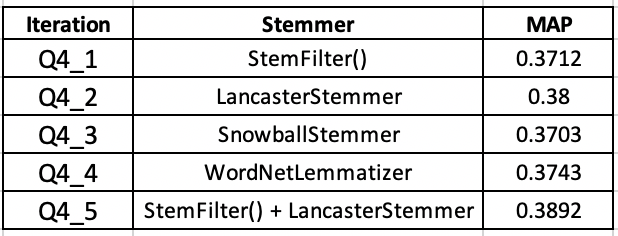

2. **Use of IntraWordFilter() and removal of numbers**

**Justification:** This analyzer was very useful for the Topic ID 4 that I chose since it works by removing the extra spaces and hyphens between words and reducing it to its respective tokens. For example, words like 'WirelessCommunications' or 'Wireless-Communications' are the same words with same meaning which needs to be tokenized into 'Wireless', 'Communications' individually. Furthermore, it was also observed that many indexes had numbers in it which are of no use in this case and hence substitution filter was used to remove numbers.

**Advantages:** Both these filters helps in reducing the index length and therby aid in better query matching. Improvement in MAP was observed when these filters were used in the analyzer.

3. **Tuning (B, K1) of the BM25F scoring algorithm**

**Justification:** The scoring algorithm works on the principle of how much the length of the document and the occurence of a term affects the score or that particular document. For example, if a term is mentioned once in a 1000 page document, it is highly unlikely that the term has anything to do with the scoring of the document. The scale at which the length of the document affects the BM25f score is governed by the parameter 'B' and the parameter 'K1' helps control the effect of term frequency of the score. Hence, there is a optimal combination of these two paramenters where the MAP value of the system can be maximized. The parameters for my system were found to be (B,K1) (0.52, 4.4) respectively.

**Advantages:** When the hyperparameters were tuned, the MAP improved significantly from 0.39 to 0.4113.

**The following table shows the improvement of MAP from the baseline model to the final model.**

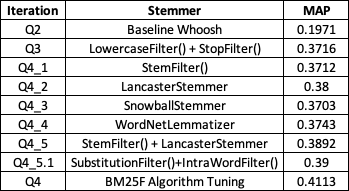

(c)  **The  final  MAP  performance  that  these  modifications  attained.**

**Answer Q4(c):** MAP = 0.4113

## Validation

In [0]:
# Run the following cells to make sure your code returns the correct value types

In [0]:
from whoosh.index import FileIndex
from whoosh.qparser import QueryParser
from whoosh.searching import Searcher
import os.path

### Q2 Validation

In [66]:
assert(isinstance(INDEX_Q2, FileIndex)), "Index Type"
assert(isinstance(QP_Q2, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q2, Searcher)), "Searcher Type"
print("Q2 Types Validated")

Q2 Types Validated


### Q3 Validation

In [67]:
assert(isinstance(INDEX_Q3, FileIndex)), "Index Type"
assert(isinstance(QP_Q3, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q3, Searcher)), "Searcher Type"
print("Q3 Types Validated")

Q3 Types Validated


### Q4 Validation

In [68]:
assert(isinstance(INDEX_Q4, FileIndex)), "Index Type"
assert(isinstance(QP_Q4, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q4, Searcher)), "Searcher Type"
print("Q4 Types Validated")

Q4 Types Validated
